In [2]:
import numpy as np
import scipy.stats as sps
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# STATS 370
## Final project

In [3]:
from plot_utils import plot_dist, plot_marginals, plot_acorr, set_plt_settings
from dist_utils import prob_post, value_mh_cand, prob_mh_cand
from dist_utils import val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam

set_plt_settings()

In [4]:
# read in data
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1, usecols=(1,2,3))
groups = data[:,0].astype(int)
Y = data[:, 1:]

## Metropolis Hasting

In [68]:
sn = 0.001
sc = 0.0001
T = 10000
xt_mh = []
cands_mh = []
status_mh = []

# Initialize then iterate
x0 = np.array((0.25, 0.5, -1, -1, 0, 0))
x = x0

for t in tqdm(range(T)):
    # 1. propose candidate according to candidate distribution
    cand = value_mh_cand(theta=x, var_n=sn, var_c=sc)
    
    # 2. Calculate acceptance probability
    post_ratio = (prob_post(theta=cand, Y=Y, groups=groups) / 
                  prob_post(theta=x, Y=Y, groups=groups))
    cand_ratio = (prob_mh_cand(x=x, theta=cand, var_n=sn, var_c=sc) / 
                  prob_mh_cand(x=cand, theta=x, var_n=sn, var_c=sc))
    prob_accept = np.minimum(1, post_ratio*cand_ratio)
    
    # 3. Accept or reject
    u = sps.uniform.rvs(loc=0, scale=1)
    if u <= prob_accept:
        cands_mh += [cand]
        status_mh += ['a']
        x = cand
        xt_mh += [cand]
    else:
        cands_mh += [cand]
        xt_mh += [x]
        status_mh += ['r']

xt_mh = np.array(xt_mh)
cands_mh = np.array(cands_mh)
status_mh = np.array(status_mh)

100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 856.14it/s]


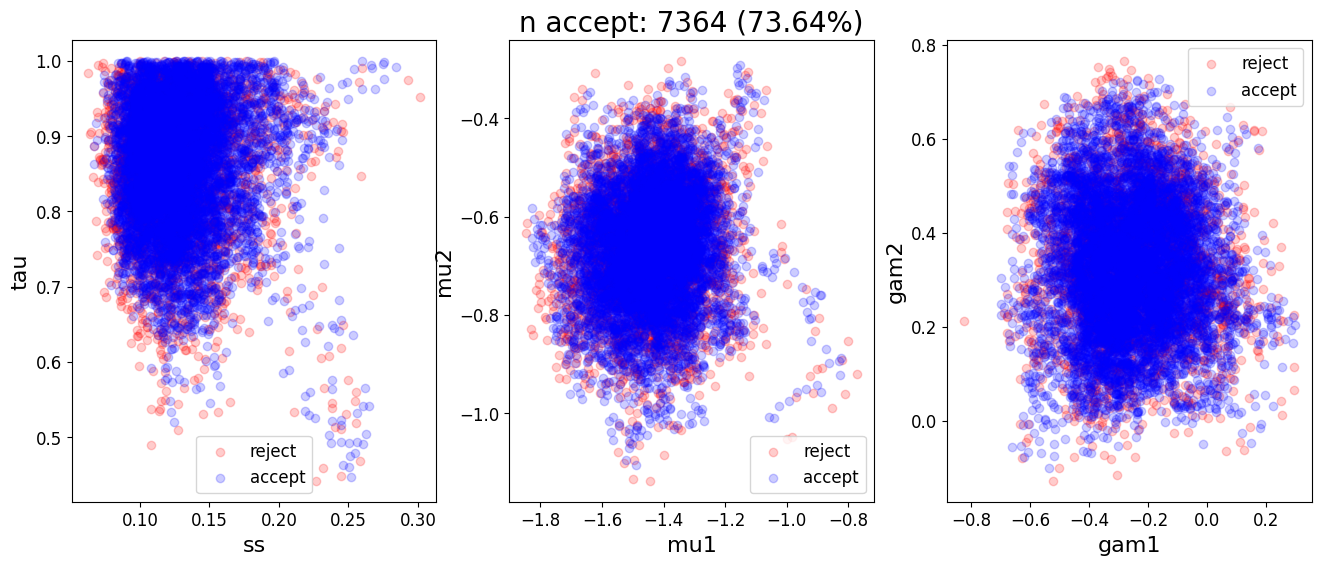

In [69]:
plot_dist(cands_mh, plot_status=True, status=status_mh)

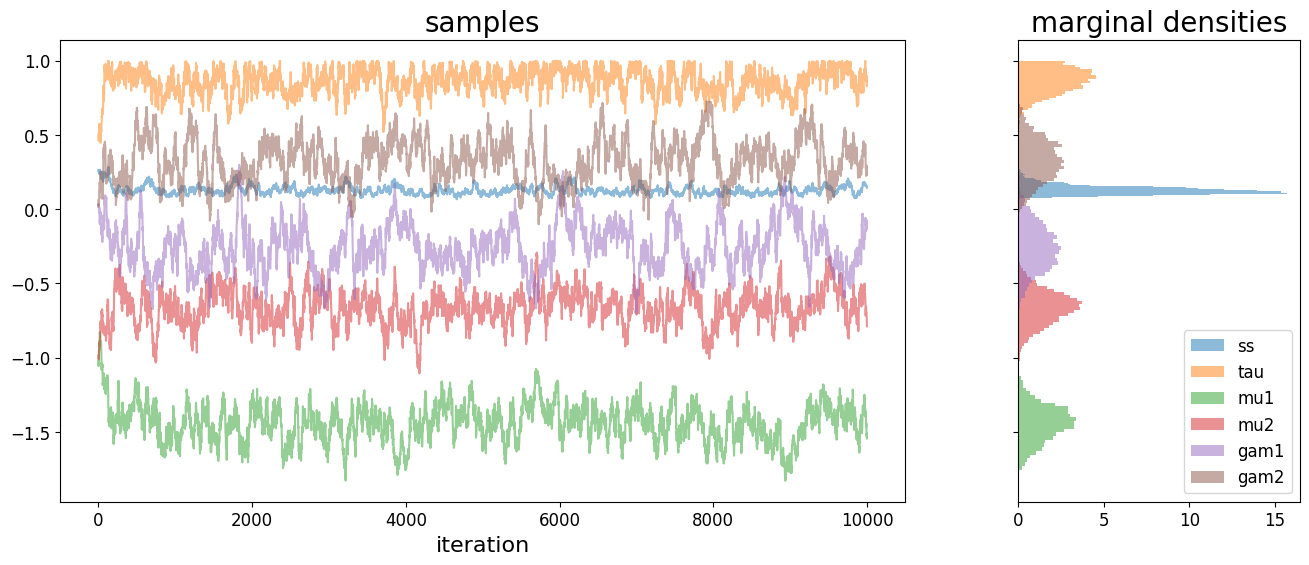

In [70]:
plot_marginals(xt_mh)

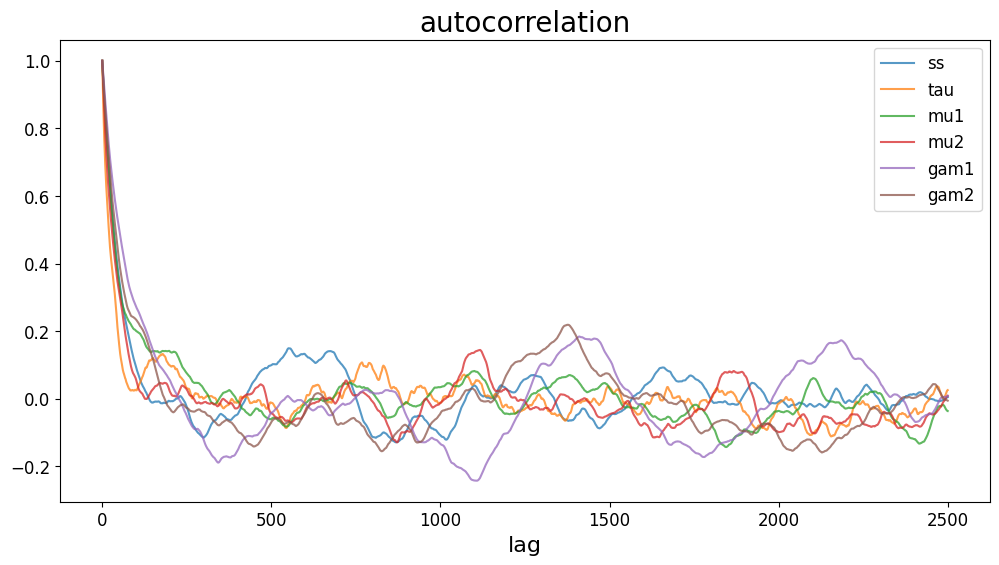

In [71]:
plot_acorr(xt_mh, nlags=2500)

In [73]:
# based on charts, summarize after trimming data
burn_in = 100
acorr_threshold = 0.3
lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=xt_mh, nlags=2500)
steps = np.argmin(np.abs(lags - acorr_threshold), axis=0)

n, d = xt_mh.shape
xt_mh_sub = []
for i in range(d):
    idx = np.arange(start=burn_in, stop=n, step=steps[i], dtype=int)
    xt_mh_sub += [xt_mh[idx,i]]

# summarize
r=2
theta_labels = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']
for i, xt in enumerate(xt_mh_sub):
    print(f'\n========= param: {theta_labels[i]} =========')
    print(f'(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])')
    print(len(xt), np.round(np.mean(xt),r), np.round(np.var(xt),r), np.round(np.var(xt),r), 
          [np.round(np.percentile(xt, pctl), r) for pctl in [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]])


========= param: ss =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
174 0.13 0.0 0.0 [0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.08]

========= param: tau =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
261 0.87 0.01 0.01 [0.57, 0.58, 0.59, 0.61, 0.64, 0.65, 0.65]

========= param: mu1 =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
180 -1.44 0.01 0.01 [-1.78, -1.78, -1.77, -1.77, -1.76, -1.75, -1.75]

========= param: mu2 =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
187 -0.66 0.01 0.01 [-0.98, -0.98, -0.98, -0.98, -0.97, -0.97, -0.97]

========= param: gam1 =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
112 -0.26 0.02 0.02 [-0.6, -0.6, -0.6, -0.59, -0.59, -0.59, -0.58]

========= param: gam2 =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
146 0.33 0.02 0.02 [0.03, 0.03, 0.03, 0.03, 0.04, 0.04, 0.05]


## Gibs sampling

In [74]:
T = 10000
xt_g = []
continuous_scan = False
cond_dists = [val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam]

# Initialize then iterate
x0 = np.array((0.1, 0.75, np.array([0,0]), np.array([0,0])), dtype=object)
x = x0

for t in tqdm(range(T)):
    # sample iteratively from conditional distributions
    # determine scan
    if continuous_scan:
        update_idx = np.array(range(4))
    else:
        update_idx = np.random.choice(range(4), 4, replace=False)
    
    for j in update_idx:
        x[j] = cond_dists[j](x, Y, groups)
    
    # record in flattened state
    xt_g += [np.hstack(x)]

xt_g = np.array(xt_g)

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1567.09it/s]


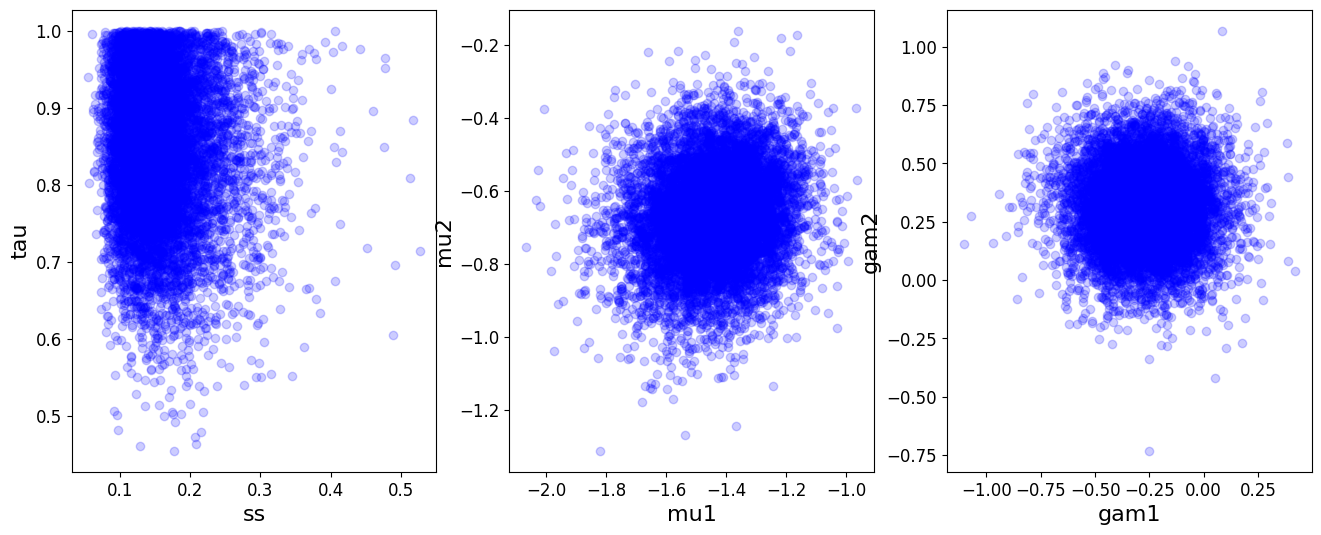

In [75]:
plot_dist(xt_g, plot_status=False)

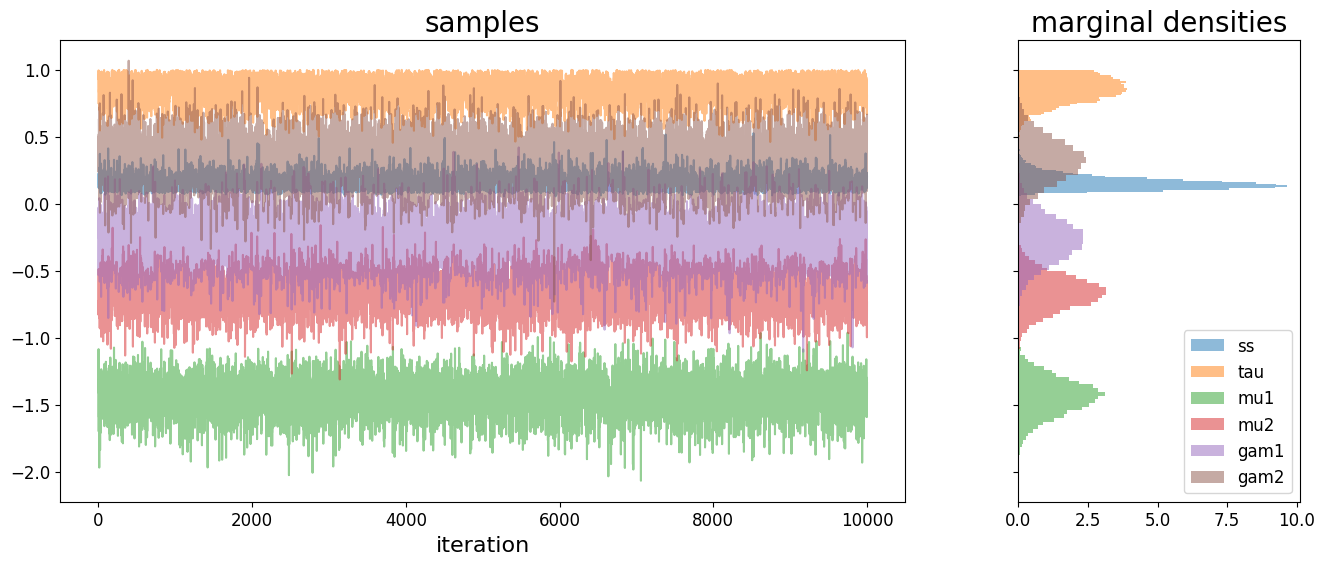

In [76]:
plot_marginals(xt_g)

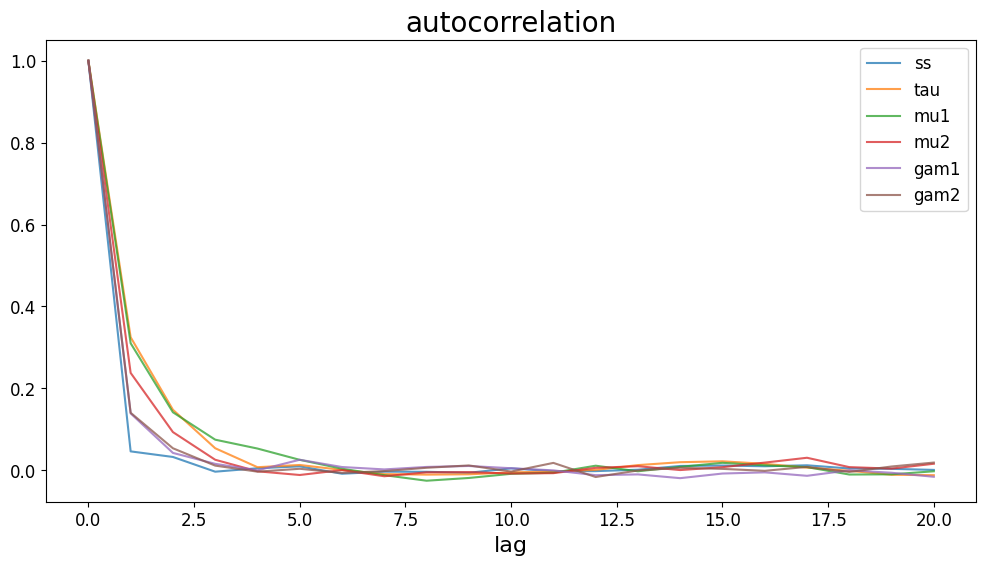

In [77]:
plot_acorr(xt_g, nlags=20)

In [78]:
# based on charts, summarize after trimming data
burn_in = 100
acorr_threshold = 0.1
lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=xt_g, nlags=2500)
steps = np.argmin(np.abs(lags - acorr_threshold), axis=0)

n, d = xt_g.shape
xt_g_sub = []
for i in range(d):
    idx = np.arange(start=burn_in, stop=n, step=steps[i], dtype=int)
    xt_g_sub += [xt_g[idx,i]]


In [79]:
# summarize
r=2
theta_labels = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']
for i, xt in enumerate(xt_g_sub):
    print(f'\n========= param: {theta_labels[i]} =========')
    print(f'(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])')
    print(len(xt), np.round(np.mean(xt),r), np.round(np.var(xt),r), np.round(np.var(xt),r), 
          [np.round(np.percentile(xt, pctl), r) for pctl in [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]])


========= param: ss =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
9900 0.16 0.0 0.0 [0.06, 0.07, 0.07, 0.08, 0.08, 0.08, 0.08]

========= param: tau =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
3300 0.85 0.01 0.01 [0.46, 0.51, 0.54, 0.57, 0.6, 0.6, 0.6]

========= param: mu1 =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
3300 -1.44 0.02 0.02 [-2.04, -1.92, -1.87, -1.83, -1.81, -1.8, -1.79]

========= param: mu2 =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
4950 -0.67 0.02 0.02 [-1.31, -1.11, -1.07, -1.04, -1.0, -0.99, -0.98]

========= param: gam1 =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
9900 -0.27 0.03 0.03 [-1.11, -0.85, -0.8, -0.74, -0.71, -0.69, -0.68]

========= param: gam2 =========
(n, mean, var, median, [p0, p10, p25, p50, p75, p90, p100])
9900 0.32 0.03 0.03 [-0.73, -0.23, -0.18, -0.13, -0.11, -0.1, -0.09]
